# トークトリアル 9

# リガンドベースファーマコフォア（Ligand-based pharmacophores）

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Pratik Dhakal, Florian Gusewski, Jaime Rodríguez-Guerra and Dominique Sydow

**注**: このノートブックのセルは一つずつ順番に実行してください。全てのセルを一度に実行することも可能ですが、NGLviewのいくつかは意図した通りに動かないかもしれません。

## このトークトリアルの目的

このトークトリアルでは、以前のトークトリアルで選択し、重ね合わせを行った既知のEGFRリガンドを用いて、各リガンドのドナー、アクセプター、そして疎水性ファーマコフォアフィーチャーを見つけます。次に、これらのフィーチャーをクラスター化し、組み合わせファーマコフォア（ensemble pharmacophore)を定義します。これは既知のEGFRリガンドのセットの特性を表し、バーチャルクリーニングによる新奇なEGFRリガンドの探索に用いることができます。

## 学習の目標

### 理論

* ファーマコフォアモデリング
  * 構造ベース（structure-based）とリガンドベース（ligand-based）ファーマコフォアモデリング
* ファーマコフォアを用いたバーチャルスクリーニング
* クラスタリング：k平均法（k-means）

### 実践

* 先のトークトリアルであらかじめ重ね合わせたリガンドを取得
* NGLViewでリガンドを表示
* ファーマコフォアフィーチャー（pharmacophore feature）を抽出
* 全リガンドのファーマコフォアフィーチャーを表示
  * 水素結合ドナー
  * 水素結合アクセプター
  * 疎水性コンタクト
* フィーチャータイプ毎にフィーチャーの座標を収集
* 組み合わせファーマコフォアの作成
  * k平均法クラスタリングの静的パラメーターを設定
  * クラスター選択の静的パラメーターを設定
  * k平均法クラスタリングとクラスター選択の関数を定義
  * フィーチャーのクラスタリング
  * 適切なクラスターの選択
  * 選択したクラスター座標の取得
* クラスターの表示
  * 水素結合ドナー
  * 水素結合アクセプター
  * 疎水性コンタクト
* 組み合わせファーマコフォアの表示


## レファレンス

* IUPACにおけるファーマコフォアの定義 
([<i>Pure & Appl. Chem</i> (1998), <b>70</b>, 1129-43](https://iupac.org/publications/pac/70/5/1129/))
* LigandScoutにおける３Dファーマコフォア 
([<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](http://pubs.acs.org/doi/pdf/10.1021/ci049885e))
* 書籍の章： Pharmacophore Perception and Applications 
([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f))
* 書籍の章： Structure-Based Virtual Screening ([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h)).
* Monty Kierとファーマコフォアの概念の起源
([<i>Internet Electron. J. Mol. Des.</i> (2007), <b>6</b>, 271-9](http://biochempress.com/Files/iejmd_2007_6_0271.pdf))
* Nik StieflによるRDKitを使ったファーマコフォアモデリングのデモンストレーション 
([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)) 

## 理論

### ファーマコフォア

コンピューター支援医薬品デザイン（computer-aided drug design）において、ファーマコフォアを用いた医薬品とターゲット分子との相互作用の表現はよく確立された手法です。ファーマコフォアという用語は1998年IUPACの作業部会によって定義されました。即ち、「ファーマコフォアは、特定の生物学的標的の構造との最適な分子間相互作用を確実なものとし、その生物学的応答を引き起こす（あるいは阻害する）ために必要な、立体的、電子的特徴の組み合わせ」です。
([<i>Pure & Appl. Chem.</i> (1998), <b>70</b>, 1129-43](https://iupac.org/publications/pac/70/5/1129/))

言い換えれば、*ファーマコフォア*はいくつかの*ファーマコフォアフィーチャー*で構成されていて、*ファーマコフォアフィーチャー*は研究対象のターゲット分子に結合することが観察されているリガンドの重要な立体的、物理化学的特性を表現します。そのような*物理化学的特性*（フィーチャータイプとも呼ばれます）としては水素結合ドナー/アクセプター、疎水性/芳香族性相互作用、あるいは、正/負電荷を帯びた官能基があり、*立体的特性*はこれらのフィーチャーの３次元配置によって定義されます。

#### 構造ベースファーマコフォアモデリングとリガンドベースファーマコフォアモデリング

ファーマコフォアモデリングには、生物学的な問いと、手に入るデータソースに応じて、２つの主要なアプローチが使われます。即ち、構造ベースファーマコフォアモデリングとリガンドベースファーマコフォアモデリングです。

*構造ベースファーマコフォアモデル(Structure-based pharmacophore models)* はタンパク質-リガンド複合体から作成されます。フィーチャーはタンパク質とリガンドの間で観察される相互作用によって定義され、リガンドの結合に関与することが示されているこれらのリガンド部位だけがバーチャルスクリーニングに使われることを保証します。
しかしながら、タンパク質-リガンド複合体の構造は全ての標的タンパク質で手に入る訳ではありません。この場合、例えばドッキングによってリガンドを標的の結合サイトにモデリングすることで複合体の構造を生成するか、あるいは、タンパク質とリガンドが相互作用する可能性がある場所を見つけるために、標的タンパク質の結合サイトだけを使ってファーコフォアモデリングを行います。

*リガンドベースファーマコフォアモデル(Ligand-based pharmacophore models)* は研究対象の標的分子に結合することが知られている一連のリガンドに基づきます。これらのリガンドに共通してみられる化学的特徴でファーマコフォアモデルを作成します。この手法は複数の既知リガンドがある標的タンパク質で、タンパク質ーリガンド複合体構造が無い場合に使われます。このトークトリアルでは、既知のEGFRリガンドセットを使ってリガンドベースのファーマコフォアモデリングを行います。

ファーマコフォアモデリングに関してさらに知りたい場合は、 ([Pharmacophore Perception and Applications: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f)) and ([<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](http://pubs.acs.org/doi/pdf/10.1021/ci049885e))をお勧めします。

<img src="images/target+ligand+pharma_3x_feather.png" align="above" alt="Image cannot be shown" width="400">
<div align="center"> Figure 1: タンパク質-リガンド相互作用を表す構造ベースのファーマコフォア（Dominique Sydowによる図）</div>

### ファーマコフォアを用いたバーチャルスクリーニング

先に**トークトリアル 4**で説明したように、バーチャルクリーニング（Virtual Screening, VS）は、（クエリによって代表される）研究対象のターゲット分子に結合する可能性が最も高い（ライブラリ中の）低分子を見つけるために、巨大な化合物ライブラリに対してクエリ（例えばこの**トークトリアル 9**ではファーマコフォアモデル、**トークトリアル 4**ではクエリ化合物）のスクリーニングを実施することです。ファーマコフォアベースのバーチャルスクリーニングでは、化合物ライブラリがファーマコフォアモデルに対して化合物毎に突き合わせられ、最も整合性の良かった結果にもとづきランク付けされます([Structure-Based Virtual Screening: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h))。

### クラスタリング：k平均法

このトークトリアルでは、いくつかのリガンドベースファーマコフォアのフィーチャーポイントをクラスタリングすることで組み合わせファーマコフォアを作成します。クラスタリングのアルゴリズムとして、データセットをk個のクラスターに分類するために使われる、k平均法クラスタリングを使います：

1. k個の異なる重心（centroid）を選択し、データセットの各ポイントを最も近い重心に割り当てる
2. 現在のクラスターに基づいて新しい重心を計算し、データセットの各ポイントが新しい重心のうち最も近いものに割り当てられる
3. 重心が安定化するまでこの過程を繰り返す

([K means wikipedia](https://de.wikipedia.org/wiki/K-Means-Algorithmus))

## 実践

In [1]:
import os, glob

# RDKit
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import ChemicalFeatures, rdDistGeom, Draw, rdMolTransforms, AllChem
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
IPythonConsole.ipython_useSVG=True

import collections
import pandas as pd
import math

from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter # For handling the labels
import operator

### 先のトークトリアルのあらかじめ重ね合わせたリガンドを取得

先のトークトリアルで重ね合わせたリガンドを取得します。

まず、全リガンドPDBファイルへのファイルパスを取得します。

In [3]:
mol_files = list(glob.glob("../data/T8/*_lig.pdb"))
mol_files

['../data/T8/5UG8_lig.pdb',
 '../data/T8/3POZ_lig.pdb',
 '../data/T8/5UG9_lig.pdb',
 '../data/T8/5HG8_lig.pdb']

In [4]:
pdb_ids = [os.path.basename(i).split("_")[0] for i in mol_files]
pdb_ids

['5UG8', '3POZ', '5UG9', '5HG8']

**訳注(2020/05)**  
まず、Python標準ライブラリの`glob`モジュールを使うことでワイルドカード`*`を使って一連のファイルのパスを取得しています。    
次に`os.path`モジュールの`basename()`で、パス文字列からファイル名を取得し、`split`で分割することで`PDB ID`だけにしています。  
**訳注ここまで**

次に、RDKitを使ってこれらのPDBファイルから全てのリガンドを読み込みます。

In [5]:
mols = []
for mol_file in mol_files:
    mol = Chem.MolFromPDBFile(mol_file, removeHs=False)
    if mol is None:
        print(mol_file, 'could not be read')
    else:
        Chem.SanitizeMol(mol)
        print(Chem.MolToSmiles(mol))
        mols.append(mol)
rangeMols = range(1, len(mols)+1)
print('Number of molecules: ', len(mols))

CCC(O)N[C@@H]1CN(C2NC(NC3CNN(C)C3)C3NCN(C(C)C)C3N2)C[C@H]1F
CC(C)(O)CC(O)NCCN1CCC2NCNC(NC3CCC(OC4CCCC(C(F)(F)F)C4)C(Cl)C3)[C@H]21
CCC(O)N[C@@H]1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C(C)C)C3N2)C[C@H]1F
CCC(O)NC1CCCC(OC2NC(NC3CNN(C)C3)NC3NCCC32)C1
Number of molecules:  4


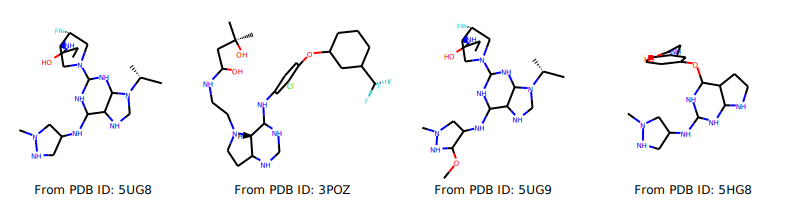

In [6]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

ここで問題に行き当たりました：PDBファイルからリガンドを読み込むと、RDKitはリガンドに対して例えば芳香環の情報を割り当てません。RDKitの関数`AssignBondOrdersFromTemplate`を使うと、リファレンス分子に基づいて分子の結合に情報を割り当てます。リファレンス分子として例えば、我々の場合化合物のSMILESパターンを使います。

もっと情報が知りたい場合は([RDKitディスカッションの「PDBの非タンパク質分子の芳香族が認識されない」](https://github.com/rdkit/rdkit/issues/1031))と ([RDKitドキュメンデーションの`AssignBondOrdersFromTemplate`](http://rdkit.org/docs/source/rdkit.Chem.AllChem.html#AssignBondOrdersFromTemplate))をチェックしてください。

In [13]:
# PDBリガンド構造のSMILESを読み込む
ligs = pd.read_csv("../data/T8/PDB_top_ligands.csv", sep="\t")

# pdb_idsと同じ順番でSMILESを取得
ligs_smiles = [ligs[ligs["@structureId"]==pdb_id]["smiles"].values[0] for pdb_id in pdb_ids]

# SMILESからRDKit Molオブジェクトを生成
refmols = [Chem.MolFromSmiles(smiles) for smiles in ligs_smiles]

# SMILESパターン（refmols）に基づき化合物（mols)に結合次数を割り当てる
mols = [AllChem.AssignBondOrdersFromTemplate(refmol, mol) for refmol, mol in zip(refmols, mols)]

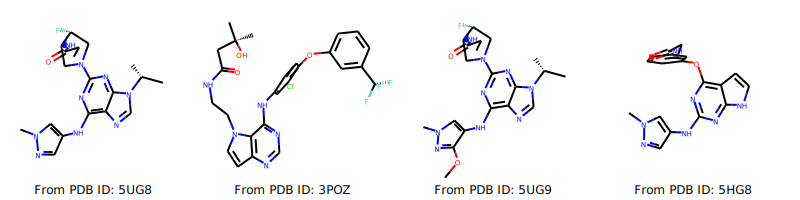

In [14]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

２次元で化合物を見ることもできます（この例では元々の座標を保持しておくために化合物をコピーしておきます）。

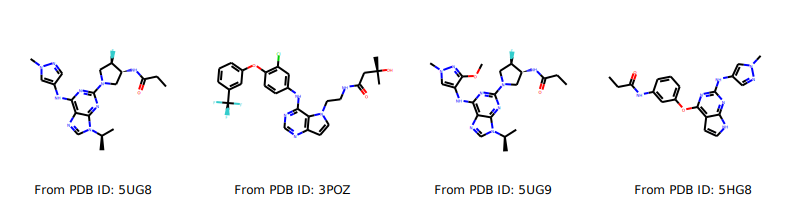

In [15]:
mols_2D = [] 
for mol in mols:
    tmp=Chem.Mol(mol)
    AllChem.Compute2DCoords(tmp)
    mols_2D.append(tmp)
Draw.MolsToGridImage(mols_2D, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

## `nglview`で可視化

`ImportError`あるいは`ModuleNotFoundError`の例外がでた場合は、下のセルのタイプを`Code`に切り替えて実行してください。

In [16]:
import nglview as nv

_ColormakerRegistry()

In [17]:
import time
def show_ligands(rdkit_mols):
    v = nv.NGLWidget()
    for mol in rdkit_mols:
        c = v.add_component(Chem.MolToPDBBlock(mol), ext="pdb")
        time.sleep(0.1)
        c.clear()
        c.add_ball_and_stick(multipleBond=True)
    return v

In [18]:
v = show_ligands(mols)
v

NGLWidget()

In [19]:
v.render_image(),

(Image(value=b'', width='99%'),)

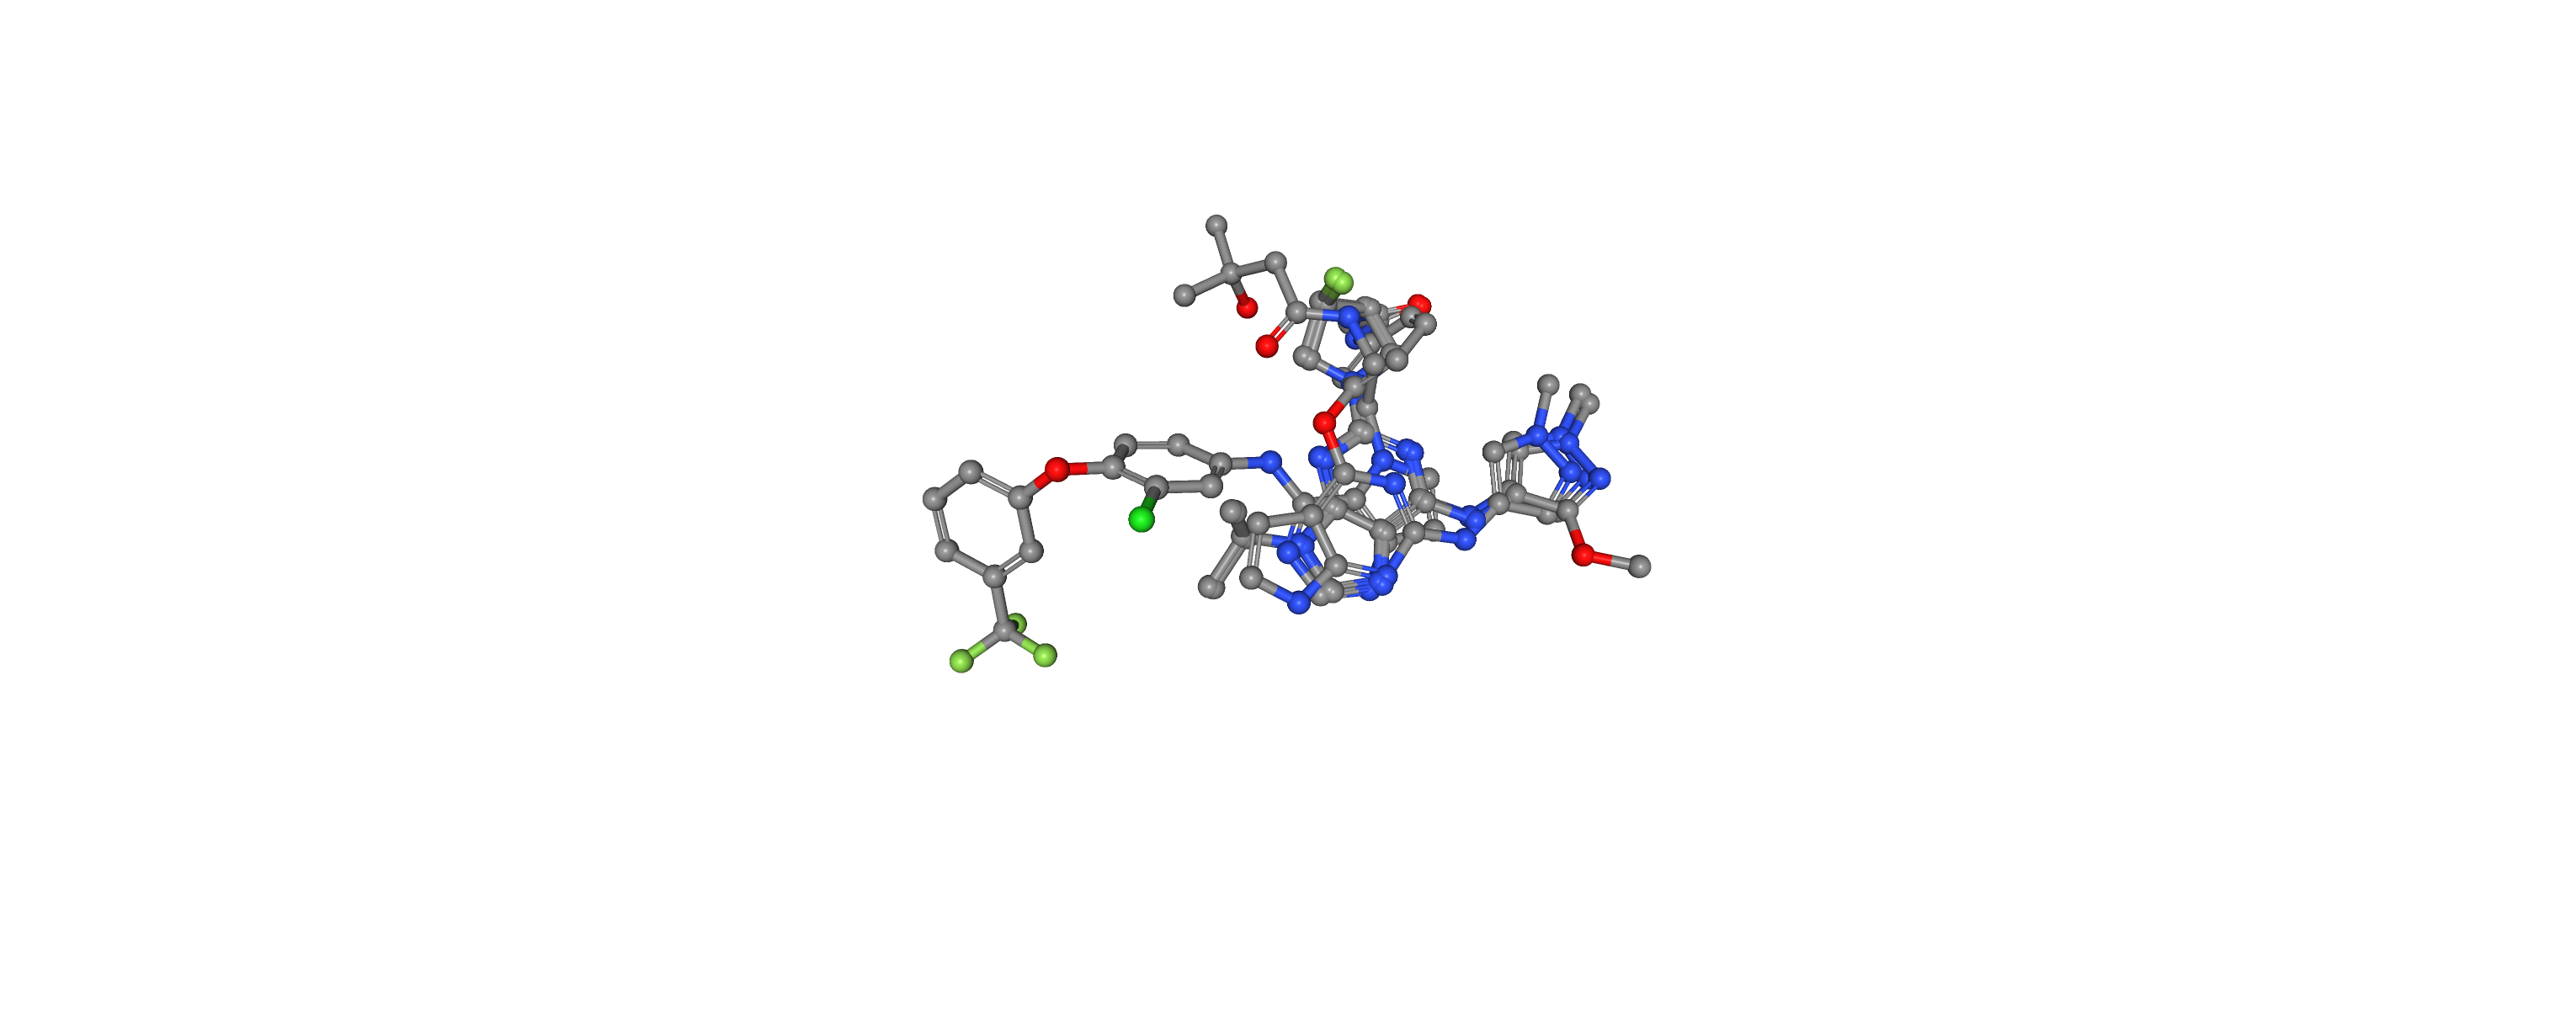

In [20]:
v._display_image()

### ファーマコフォアフィーチャーの抽出

上で述べたように、このトークトリアルの目的はリガンドセットからリガンドベースのファーマコフォアの組み合わせを作成することです。まず最初に、リガンド毎にファーマコフォアフィーチャーを取り出す必要があります。そこで、フィーチャーファクトリーを（デフォルトのフィーチャーの定義で）読み込みます。

[RDKitドキュメンテーションの「chemical features and pharmacophores」](https://rdkit.readthedocs.io/en/latest/GettingStartedInPython.html#chemical-features-and-pharmacophores)も参照してください。.

In [21]:
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

RDKitに実装されているファーマコフォアフィーチャーを見てみましょう。

In [15]:
list(ffact.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

一例として、参考例の化合物の全てのフィーチャーを取得してみます。

In [22]:
m1 = mols[0]
feats = ffact.GetFeaturesForMol(m1)
print('Number of features found:',len(feats))

Number of features found: 14


フィーチャーのタイプ（RDKitではfamilyと呼ばれています）は`GetFamily()`で取得することができます。

In [23]:
feats[0].GetFamily()

'Donor'

参考例の化合物のフィーチャーのタイプについてその頻度を取得します。

In [24]:
feats_freq = collections.Counter([x.GetFamily() for x in feats])
feats_freq

Counter({'Donor': 2,
         'Acceptor': 6,
         'PosIonizable': 1,
         'Aromatic': 3,
         'Hydrophobe': 1,
         'LumpedHydrophobe': 1})

**訳注(2020/05)**  
Python標準ライブラリ`collections`の`Counter`クラスにより、与えられたリストの要素の出現頻度について辞書型オブジェクトが生成されています。keyが要素、値が出現頻度で、ここではフィーチャータイプと頻度の辞書になっています。  
**訳注ここまで**

上記の関数をリガンドセットの全化合物に適用します。化合物ごとのフィーチャータイプの頻度をデータフレームとして表示します。

In [25]:
# 化合物ごとのフィーチャータイプの頻度を取得
mols_feats_freq = []
for i in mols:
    feats = [x.GetFamily() for x in ffact.GetFeaturesForMol(i)]
    feats_freq = collections.Counter(feats)
    mols_feats_freq.append(feats_freq)

# データをデータフレームとして表示
p = pd.DataFrame(mols_feats_freq, index=["m"+str(i) for i in range(1, len(mols)+1)]).fillna(0).astype(int)
p.transpose()

m1  m2  m3  m4
Donor              2   3   2   4
Acceptor           6   5   7   5
PosIonizable       1   0   1   0
Aromatic           3   4   3   4
Hydrophobe         1   3   1   2
LumpedHydrophobe   1   2   1   1

この先、このトークとリアルでは次のフィーチャータイプのみに焦点をあてます。すなわち水素結合アクセプター（acceptors）、水素結合ドナー（donors）、そして疎水性コンタクト（hydrophobics）です。

フィーチャータイプごと、そして化合物ごとに、RDKitのフィーチャーオブジェクトを取得します。

In [26]:
acceptors = []
donors = []
hydrophobics = []

for i in mols:
    acceptors.append(ffact.GetFeaturesForMol(i, includeOnly='Acceptor'))
    donors.append(ffact.GetFeaturesForMol(i, includeOnly='Donor'))
    hydrophobics.append(ffact.GetFeaturesForMol(i, includeOnly='Hydrophobe'))
    
features = {"donors": donors,
            "acceptors": acceptors,
            "hydrophobics": hydrophobics}

### 全てのリガンドのファーマコフォアフィーチャーを表示

ファーマコフォアフィーチャーのタイプは大抵の場合、定義された色で表示されます。例えば、水素結合ドナー、水素結合アクセプターそして、疎水性コンタクトはそれぞれ緑、赤、黄色でよく表されます。

In [27]:
feature_colors = {"donors": (0,0.9,0),  # Green
                  "acceptors": (0.9,0,0),  # Red 
                  "hydrophobics": (1,0.9,0)}  # Yellow

In [28]:
def visualize_features(molecules, feature_type, features, color="yellow", sphere_radius=0.5):
    print("Number of", feature_type, "in all ligands:", sum([len(i) for i in features]))
    v = show_ligands(molecules)
    for i, feature in enumerate(features, 1):
        for feat in feature:
            loc = list(feat.GetPos())
            label = f"{feature_type}_{i}"
            v.shape.add_sphere(loc, color, sphere_radius, label)
    return v

考察中のフィーチャータイプのフィーチャーを可視化するためにこの関数を使います。

#### 水素結合ドナー

In [29]:
feature_type = "donors"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of donors in all ligands: 11


NGLWidget()

In [30]:
v.render_image(),

(Image(value=b'', width='99%'),)

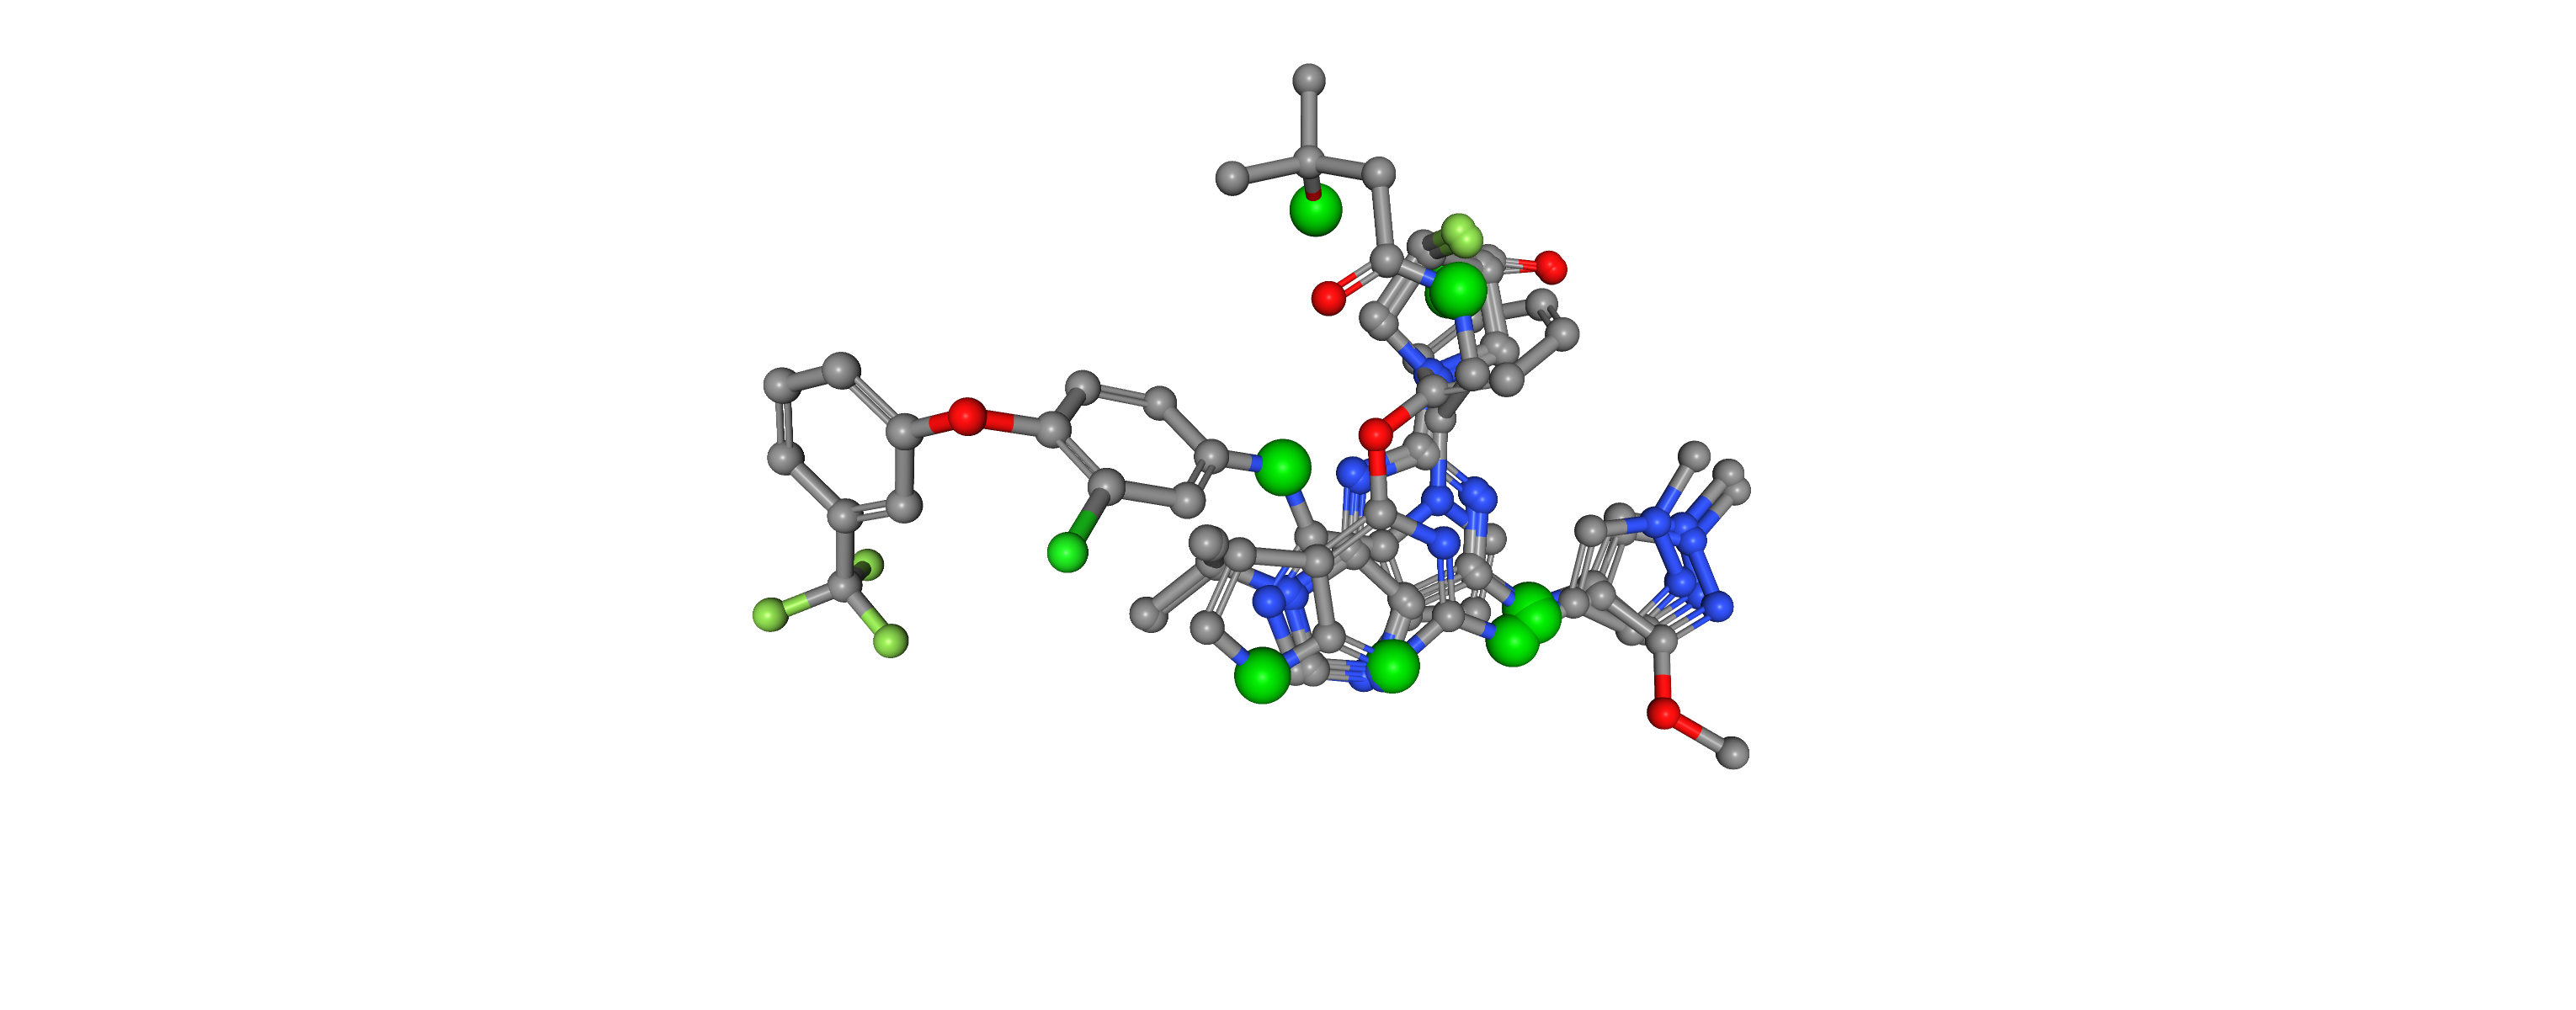

In [31]:
v._display_image()

#### 水素結合アクセプター

In [41]:
feature_type = "acceptors"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of acceptors in all ligands: 23


NGLWidget()

In [42]:
v.render_image(),

(Image(value=b'', width='99%'),)

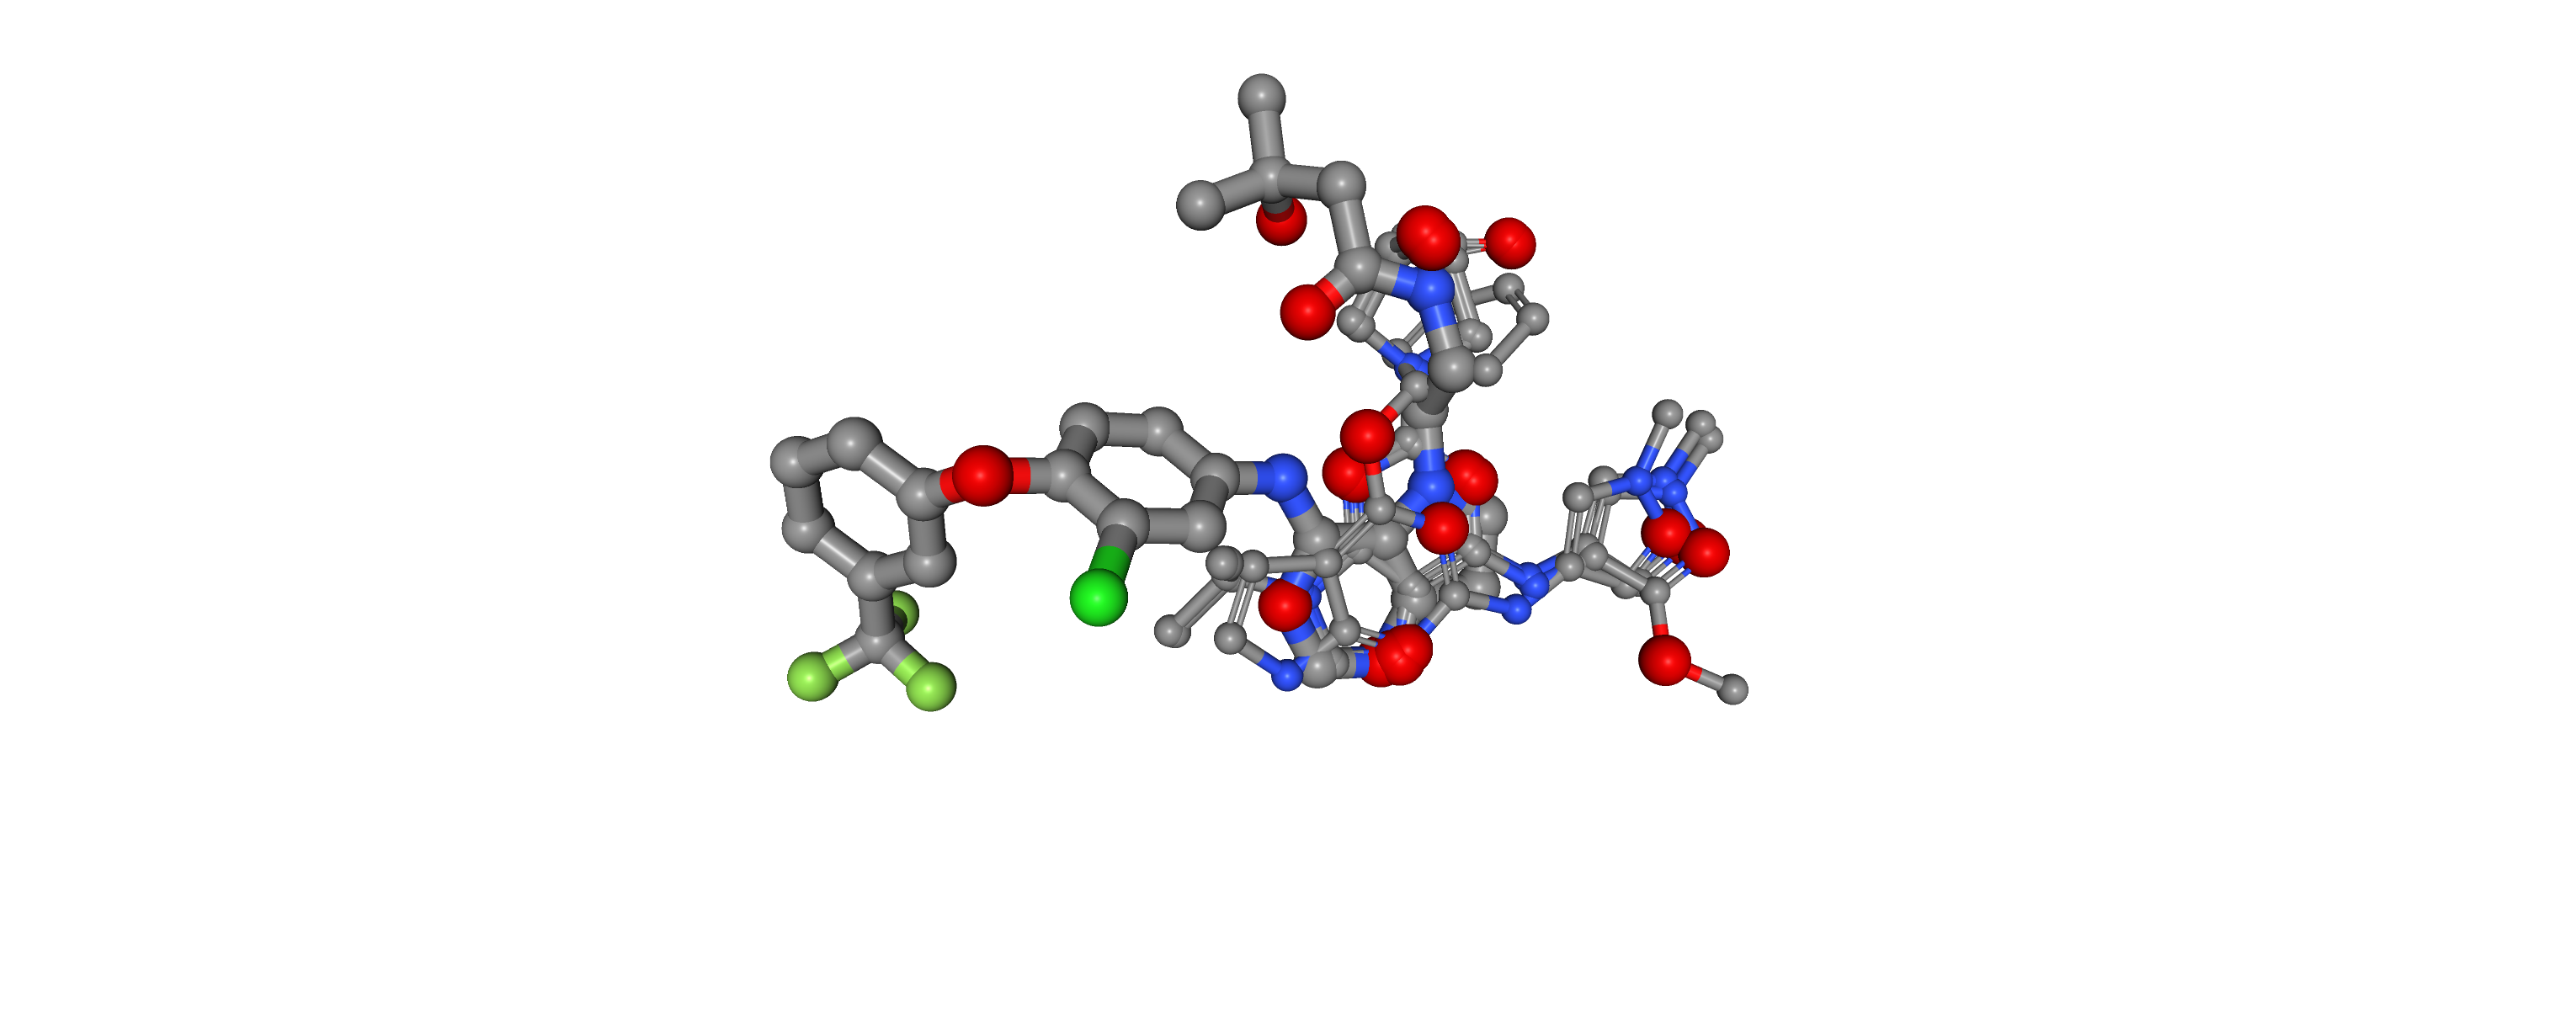

In [43]:
v._display_image()

#### 疎水性コンタクト

In [36]:
feature_type = "hydrophobics"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of hydrophobics in all ligands: 7


NGLWidget()

In [37]:
v.render_image(),

(Image(value=b'', width='99%'),)

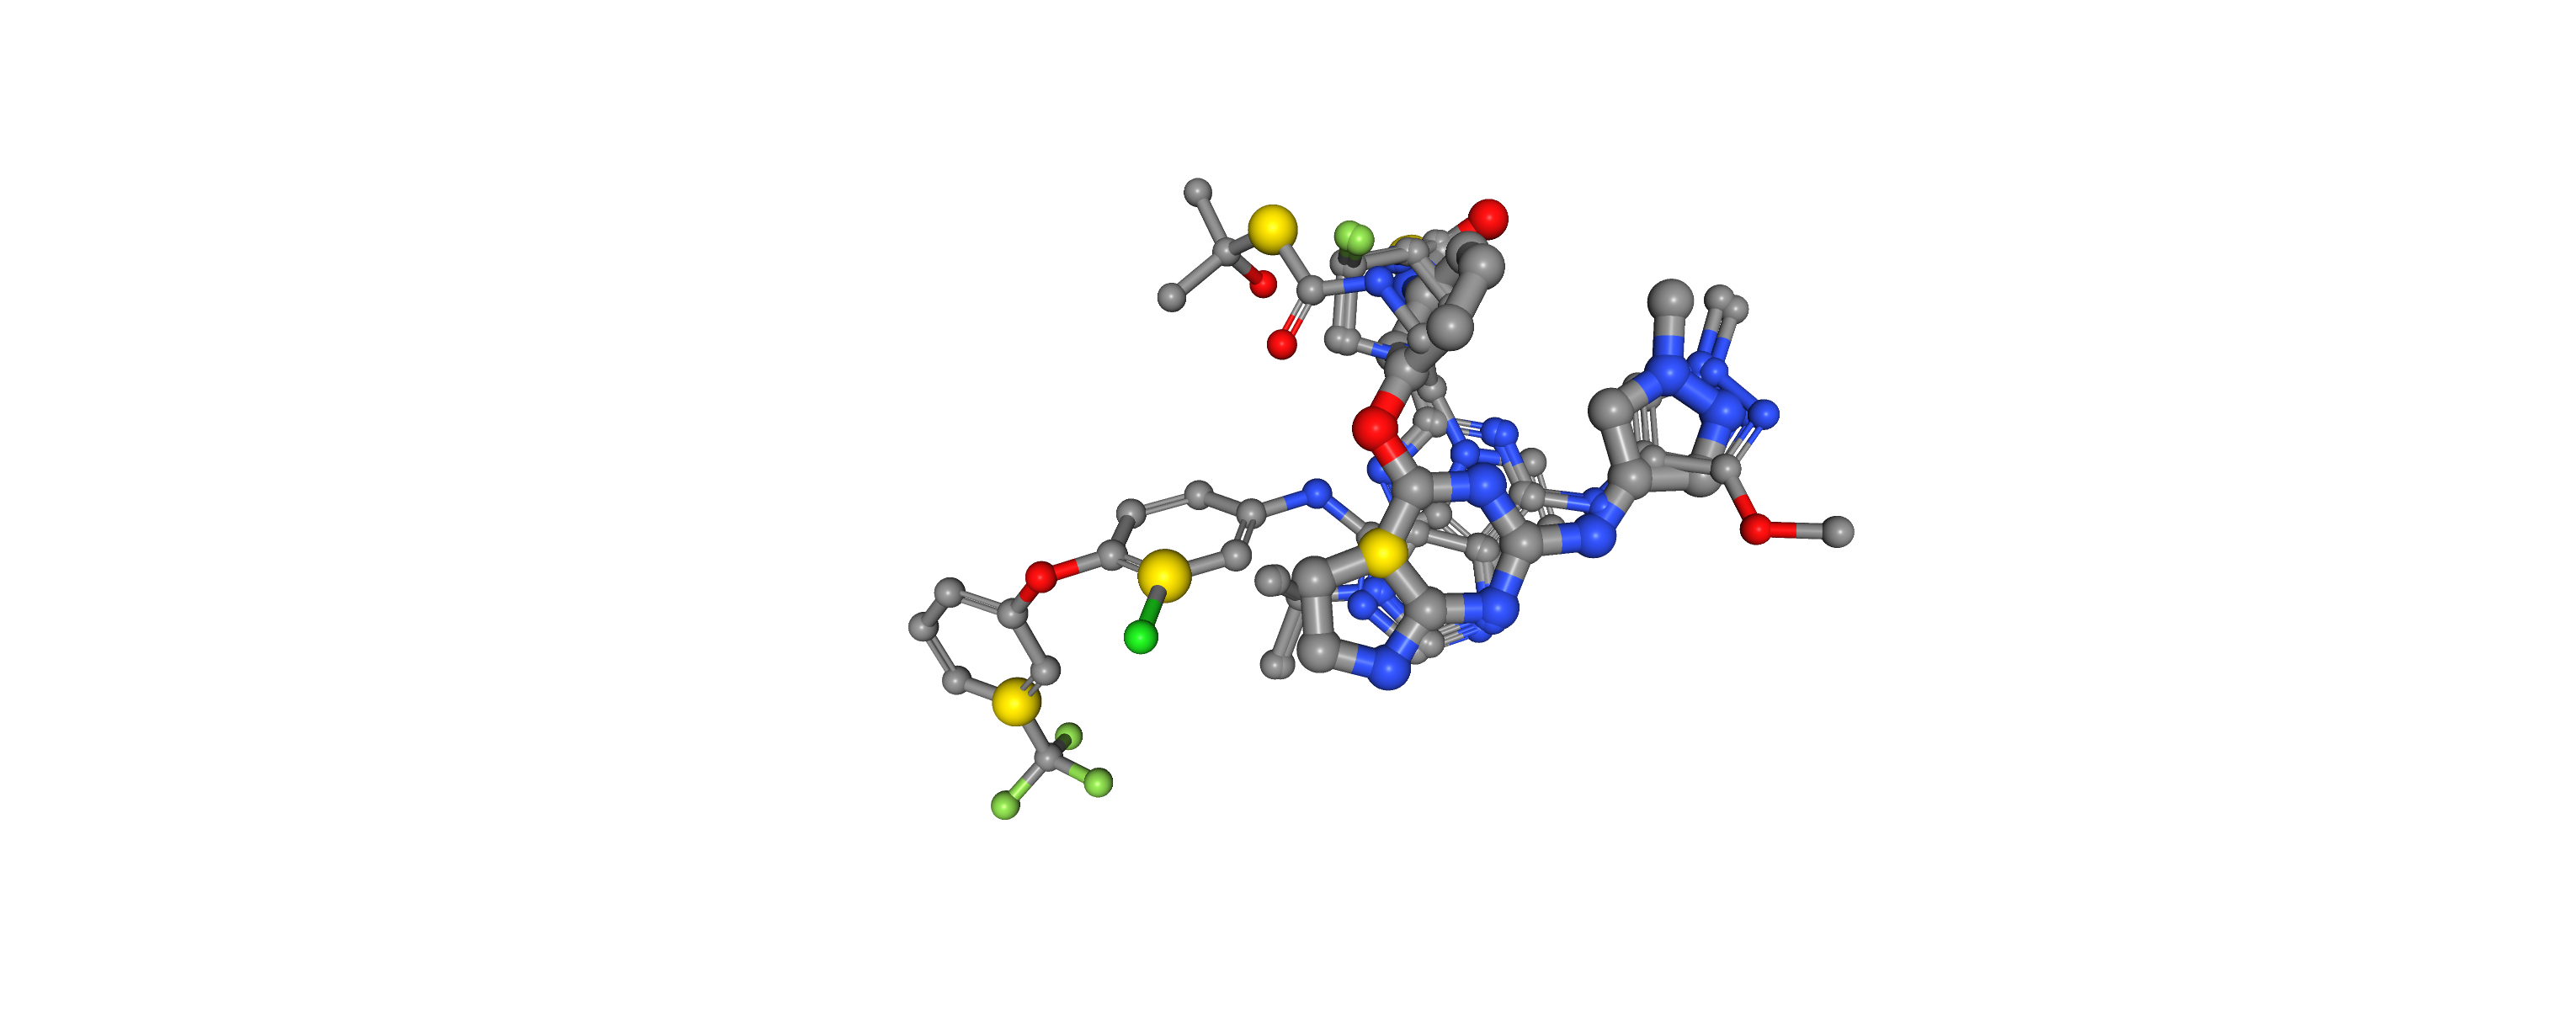

In [38]:
v._display_image()

### フィーチャータイプ毎にフィーチャーの座標を集める

（フィーチャータイプ毎に）フィーチャーをクラスタリングしたいので、（フィーチャータイプ毎に）フィーチャーのすべての座標を集めます。

In [44]:
features_coord = {"donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
                  "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
                  "hydrophobics": [list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist]}

これで全てのフィーチャーの座標が手に入りました。例えばacceptorフィーチャーの全ての座標は次のようになります。

In [46]:
features_coord["acceptors"]

[[-13.788, 14.818, -27.097],
 [-12.118, 16.261, -28.026],
 [-11.376, 12.959, -29.238],
 [-16.74, 10.887, -25.841],
 [-16.005, 17.279, -22.5],
 [-15.388, 19.42, -27.168],
 [-11.052, 12.941, -29.208],
 [-12.995, 19.311, -27.816],
 [-10.269, 15.094, -29.72],
 [-8.077, 20.488, -31.958],
 [-12.686, 20.459, -24.958],
 [-13.863, 14.66, -27.134],
 [-12.175, 16.118, -27.994],
 [-11.411, 12.856, -29.266],
 [-17.026, 10.809, -26.396],
 [-15.601, 9.901, -28.086],
 [-16.044, 17.165, -22.506],
 [-15.445, 19.229, -27.215],
 [-13.162, 14.493, -28.185],
 [-11.603, 12.928, -29.136],
 [-12.896, 16.874, -28.352],
 [-16.001, 17.24, -22.411],
 [-16.523, 11.38, -26.098]]

### 組み合わせファーマコフォアの作成

組み合わせファーマコフォアを作成するために、k平均法クラスタリングをつかってフィーチャータイプ毎にフィーチャーをクラスタリングします。

#### k平均法クラスタリングの静的パラメーターを設定

`kq`: このパラメーターで、フィーチャーポイントの数に応じてフィーチャータイプ毎のクラスター数 `k` を決定します。つまり、フィーチャータイプ毎に：

`k` = number_of_features / `kq`

となります。

In [57]:
# k quotient (kq) はk平均法でkを決めるために使われます： k = number of feature points / kq
# kq は全てのクラスターについてk（フィーチャークラスター）が少なくとも1クラスターで、4-5クラスターよりも大きくならないように選択するべきです。
kq = 7

#### クラスター選別のための静的パラメーターを設定

`min_cluster_size`: リガンドの集合のなかのほとんどの化合物がもっているフィーチャーを含む可能性があるクラスターだけを残します。したがって、この変数は、我々のリガンドの集合の化合物数の75%に設定します。

`top_cluster_number`: このパラメーターで、最も大きいクラスターだけを選択します。

In [58]:
# クラスタリングの閾値：数値=閾値のパーセンテージ
min_cluster_size = int(len(mols) * 0.75)

# 上位のフィーチャーだけを表示
top_cluster_number = 4

#### k平均法クラスタリングとクラスター選択の関数を定義

k平均法クラスタリングから導いたクラスターの中心を計算する関数を定義します。

In [59]:
def clustering(feature_coord, kd):
    '''
    この関数は入力のフィーチャーの座標のk平均法クラスタリングを計算します
    '''
    
    # パラメーターkを、"k quotient"でフィーチャーの数を割った値として定義
    k = math.ceil(len(feature_coord) / kq)
    k = 2 if k == 1 else k  # このトークトリアルの例のにあうように疎水性コンタクトのkを調整
    print('Clustering: \nVariable k in k-means: %d of %d points\n'%(k, len(feature_coord)))
    
    # k平均法を初期化
    k_means = cluster.KMeans(n_clusters=k)
    
    # k平均法クラスタリングを計算
    k_means.fit(feature_coord)
    
    # クラスターを返す
    return k_means 

クラスターをサイズで並べ替え、最も大きいクラスターのインデックスのリストを出力する関数を定義します。

In [60]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    '''
    この関数は入力されたk平均法クラスタリングの情報を取得します：
    * 各フィーチャーのクラスターのラベルを取得
    * クラスターのサイズを数え、クラスターサイズによってクラスターのインデックスを並べ替える
    * サイズに基づきクラスターを選択
    * 選択したクラスターのインデックスを返す
    '''
    
    # サイズによってクラスターを並べ替え、最大のもののみを表示
    feature_labels = k_means.labels_
    print('Cluster labels for all features: \n%s\n'% feature_labels)

    feature_labels_count = Counter(feature_labels)
    print('Cluster label counter: \n%s\n'% feature_labels_count)

    feature_labels_count = sorted(feature_labels_count.items(), 
                                  key=operator.itemgetter(1), 
                                  reverse=True)
    print('Sorted cluster label counters: \n%s\n'% feature_labels_count)

    # 閾値よりも大きなクラスターで、最大のものの番号を取得（選択されたクラスター）
    cluster_indices_sel = []
    
    for cluster_index, cluster_size in feature_labels_count:  # feature_labels_count = list of (cluster_index, cluster_size)
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1
            
    print('Cluster indices of selected clusters: \n%s\n'% cluster_indices_sel)
    
    return cluster_indices_sel

**訳注(2020/05)**  
`feature_labels_count`は、`collections`の`Counter`でクラスターのラベルを集計（要素の出現頻度の辞書を作成）した後に並べ替えています。`counter`クラスは辞書型で順番が保証されないので、`items()`と`sorted()`を使うことでソートされたタプル`(key, value)`のリストを得ています。辞書のvalueでソートしたいので、`sorted()の引数のkey`に、`operator.itemgetter()`を使用しています。（`itemgetter(0)`ではなく）`itemgetter(1)`とすることで辞書のvalueが使われることになります。  
**訳注ここまで**

#### フィーチャーをクラスタリング

各フィーチャータイプについて、定義した`clustering`関数を使ってk平均法クラスタリングを実施します。


In [61]:
k_means = {"donors": clustering(features_coord["donors"], kq), 
           "acceptors": clustering(features_coord["acceptors"], kq),
           "hydrophobics": clustering(features_coord["hydrophobics"], kq)}

Clustering: 
Variable k in k-means: 2 of 11 points

Clustering: 
Variable k in k-means: 4 of 23 points

Clustering: 
Variable k in k-means: 2 of 7 points



#### 適切なクラスターの選択

各フィーチャータイプについて、定義した`get_clusters`関数をつかって適切なクラスターを選択します。

In [62]:
print("Hydrogen bond donors\n")
cluster_indices_sel_don = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Cluster labels for all features: 
[1 0 0 0 1 1 0 1 1 0 1]

Cluster label counter: 
Counter({1: 6, 0: 5})

Sorted cluster label counters: 
[(1, 6), (0, 5)]

Cluster indices of selected clusters: 
[1, 0]



In [63]:
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acc = get_clusters(k_means["acceptors"], min_cluster_size, top_cluster_number)

Hydrogen bond acceptors

Cluster labels for all features: 
[0 0 0 2 1 1 0 1 0 3 1 0 0 0 2 2 1 1 0 0 0 1 2]

Cluster label counter: 
Counter({0: 11, 1: 7, 2: 4, 3: 1})

Sorted cluster label counters: 
[(0, 11), (1, 7), (2, 4), (3, 1)]

Cluster indices of selected clusters: 
[0, 1, 2]



In [64]:
print("Hydrophobic contacts\n")
cluster_indices_sel_h = get_clusters(k_means["hydrophobics"], min_cluster_size, top_cluster_number)

Hydrophobic contacts

Cluster labels for all features: 
[1 0 0 1 1 0 1]

Cluster label counter: 
Counter({1: 4, 0: 3})

Sorted cluster label counters: 
[(1, 4), (0, 3)]

Cluster indices of selected clusters: 
[1, 0]



In [65]:
cluster_indices_sel = {"donors": cluster_indices_sel_don, 
                       "acceptors": cluster_indices_sel_acc, 
                       "hydrophobics": cluster_indices_sel_h}

#### 選択したクラスターの座標を取得

In [66]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel, feature_type):
    '''
    この関数は選択したクラスターのクラスター中心の座標を（インデックスで）取得します。
    '''
    
    # ある特定のフィーチャータイプについてクラスター中心を取得
    cluster_centers = k_means[feature_type].cluster_centers_
    
    # （インデックスにより要素を選択するために）リストに型変換したのち、PandasのSeriesに型変換する
    cluster_centers = pd.Series(cluster_centers.tolist())
    
    # 選択したクラスターのインデックスでクラスター中心を選択
    cluster_centers_sel = cluster_centers[cluster_indices_sel[feature_type]]
    
    # リストに型変換しリストを返す
    return list(cluster_centers_sel)

In [67]:
cluster_centers_sel = {"donors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "donors"),
                       "acceptors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "acceptors"),
                       "hydrophobics": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "hydrophobics")}

In [68]:
cluster_centers_sel["acceptors"]

[[-12.155727272727272, 14.545636363636364, -28.48690909090909],
 [-14.937714285714286, 18.586142857142857, -24.93914285714286],
 [-16.4725, 10.744250000000001, -26.605249999999998]]

### クラスターを表示

フィーチャータイプ毎に、全ての化合物と全てのフィチャーポイントと一緒にクラスター中心を可視化します。

In [69]:
def visualize_clusters(molecules, feature_type, features, clusters, 
                       color="yellow", feature_radius=0.5, cluster_radius=1):
    v = visualize_features(molecules, feature_type, features, color=color, sphere_radius=feature_radius)
    for i, center in enumerate(clusters, 1):
        v.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return v

#### 水素結合ドナー

In [70]:
feature_type = "donors"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])
v

Number of donors in all ligands: 11


NGLWidget()

In [71]:
v.render_image(),

(Image(value=b'', width='99%'),)

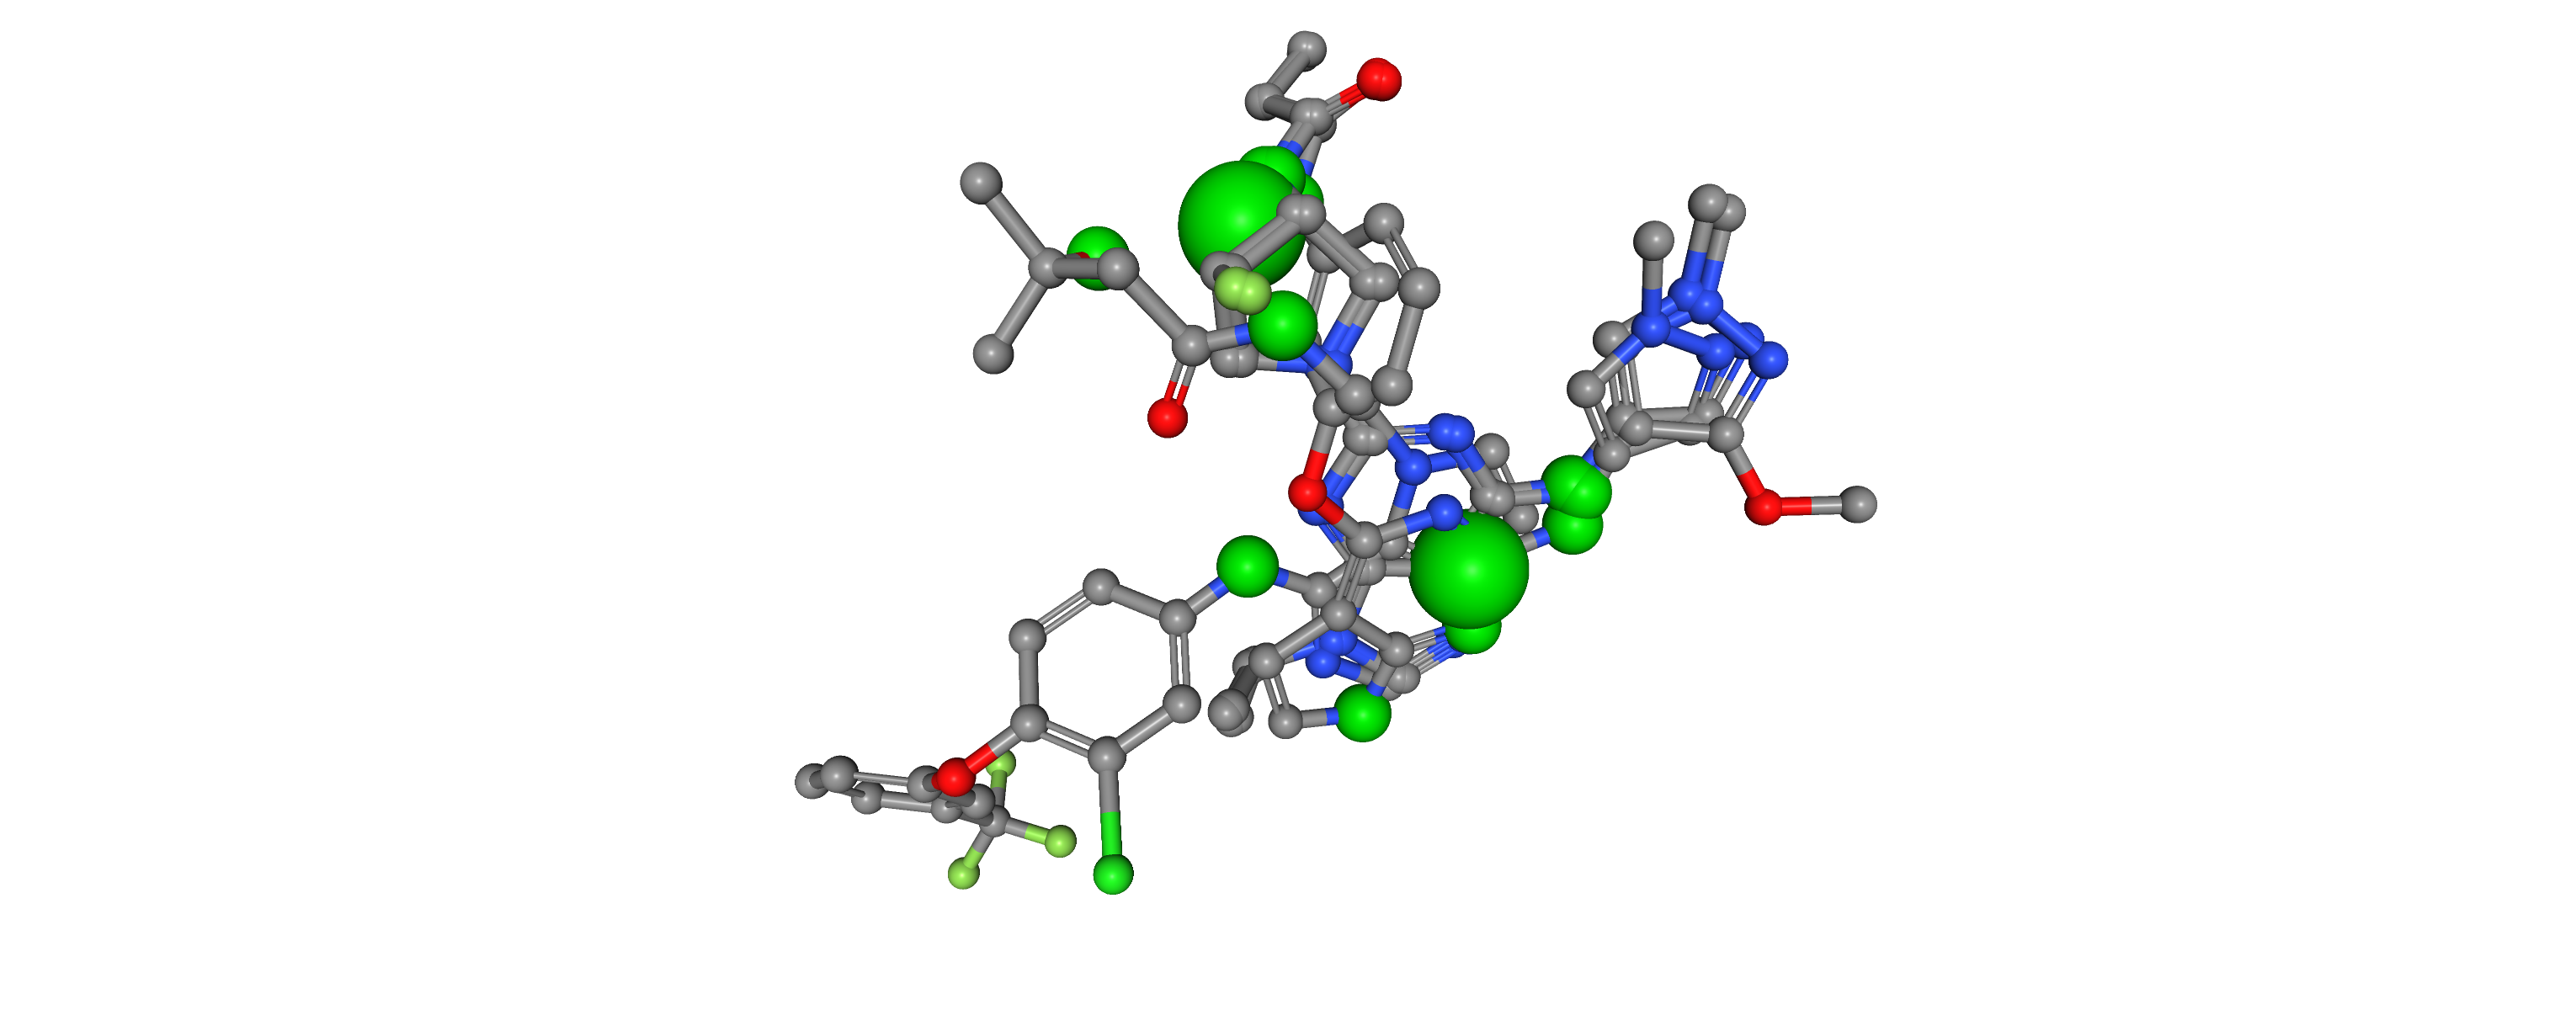

In [72]:
v._display_image()

#### 水素結合アクセプター

In [73]:
feature_type = "acceptors"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type],  
                   feature_colors[feature_type])
v

Number of acceptors in all ligands: 23


NGLWidget()

In [76]:
v.render_image(),

(Image(value=b'', width='99%'),)

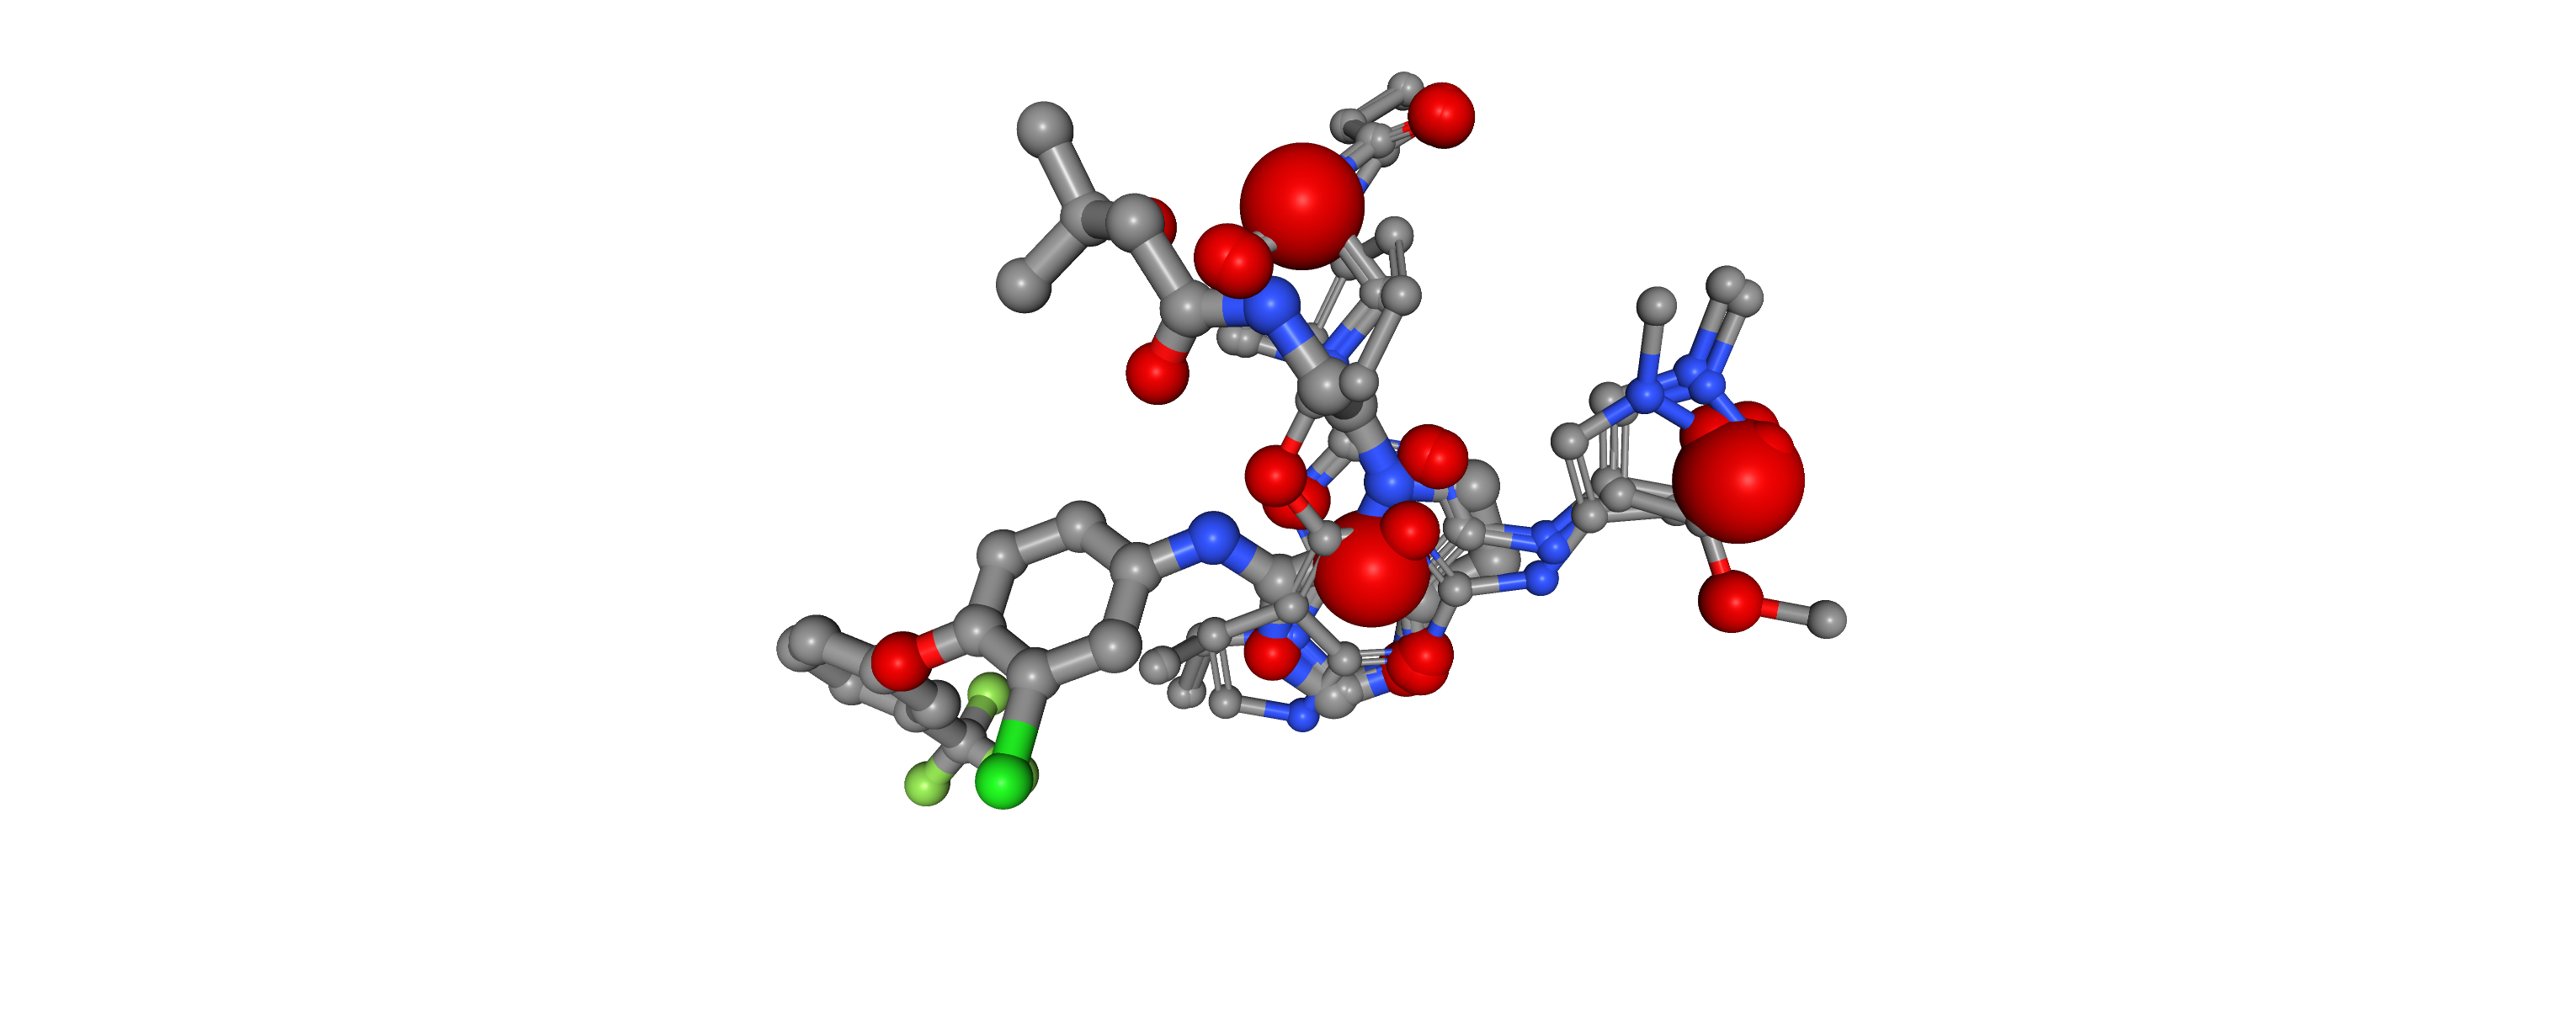

In [77]:
v._display_image()

#### 疎水性コンタクト

In [78]:
feature_type = "hydrophobics"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])
v

Number of hydrophobics in all ligands: 7


NGLWidget()

In [79]:
v.render_image(),

(Image(value=b'', width='99%'),)

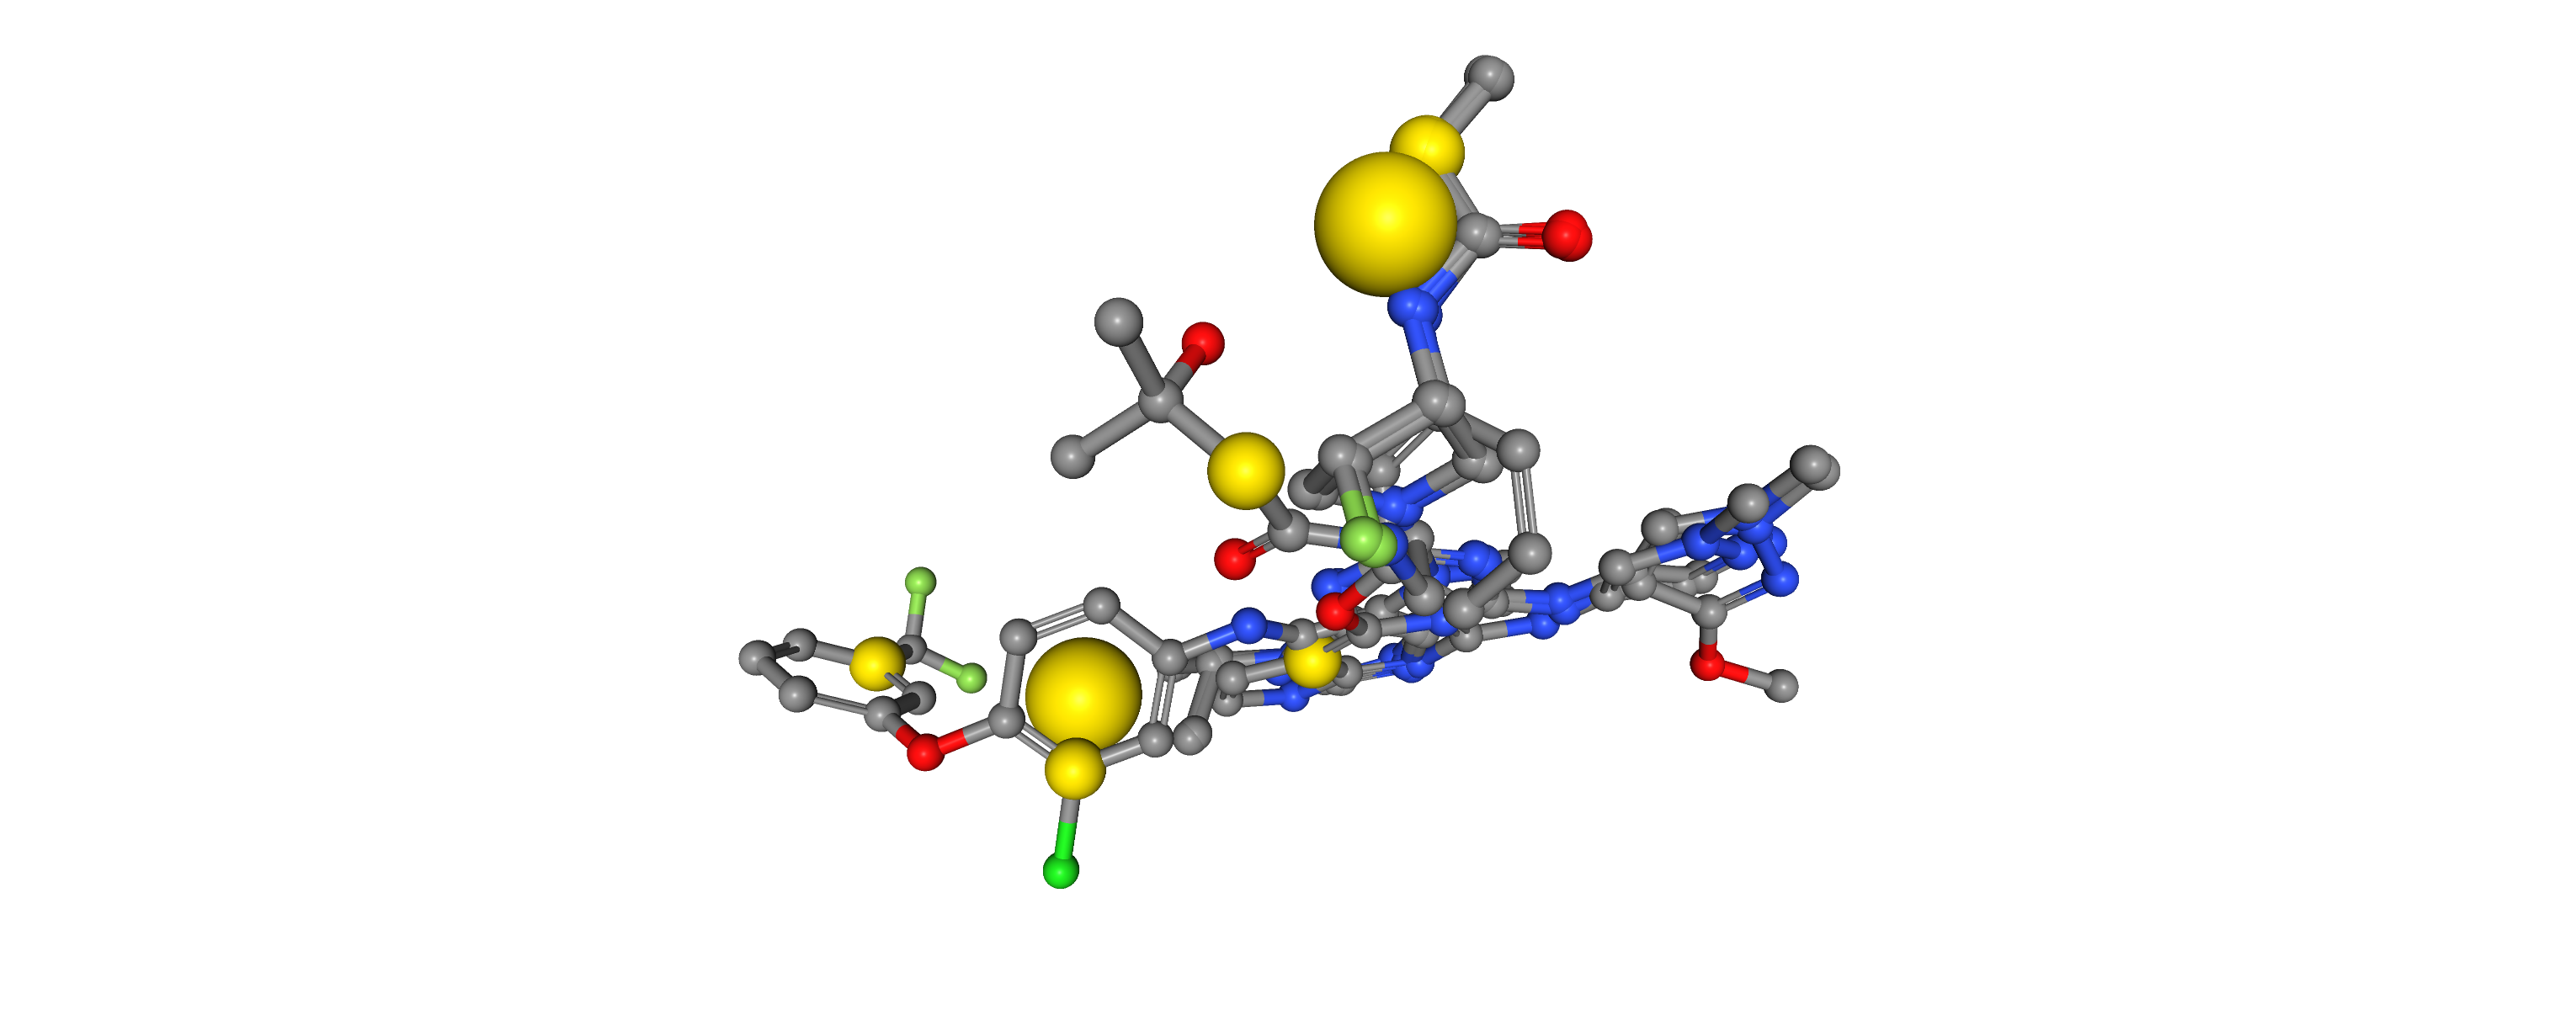

In [80]:
v._display_image()

### 組み合わせファーマコフォアの表示

この最後のステップでは、クラスタリングしたファーマコフォアのフィーチャー（即ち、水素結合ドナー、アクセプターと疎水性コンタクト）を組み合わせて、一つの組み合わせファーマコフォアを作成します。この組み合わせファーマコフォアは４つの選択したリガンドのファーマコフォアの特徴を表します。

In [81]:
v = show_ligands(mols)
# クラスターの読み込み
for feature_type in cluster_indices_sel.keys():
    centers = cluster_centers_sel[feature_type]
    for i, loc in enumerate(centers):
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = f"{feature_type}_c{i}"
        v.shape.add_sphere(loc, feature_color, sphere_radius, label)
v

NGLWidget()

In [82]:
v.render_image(),

(Image(value=b'', width='99%'),)

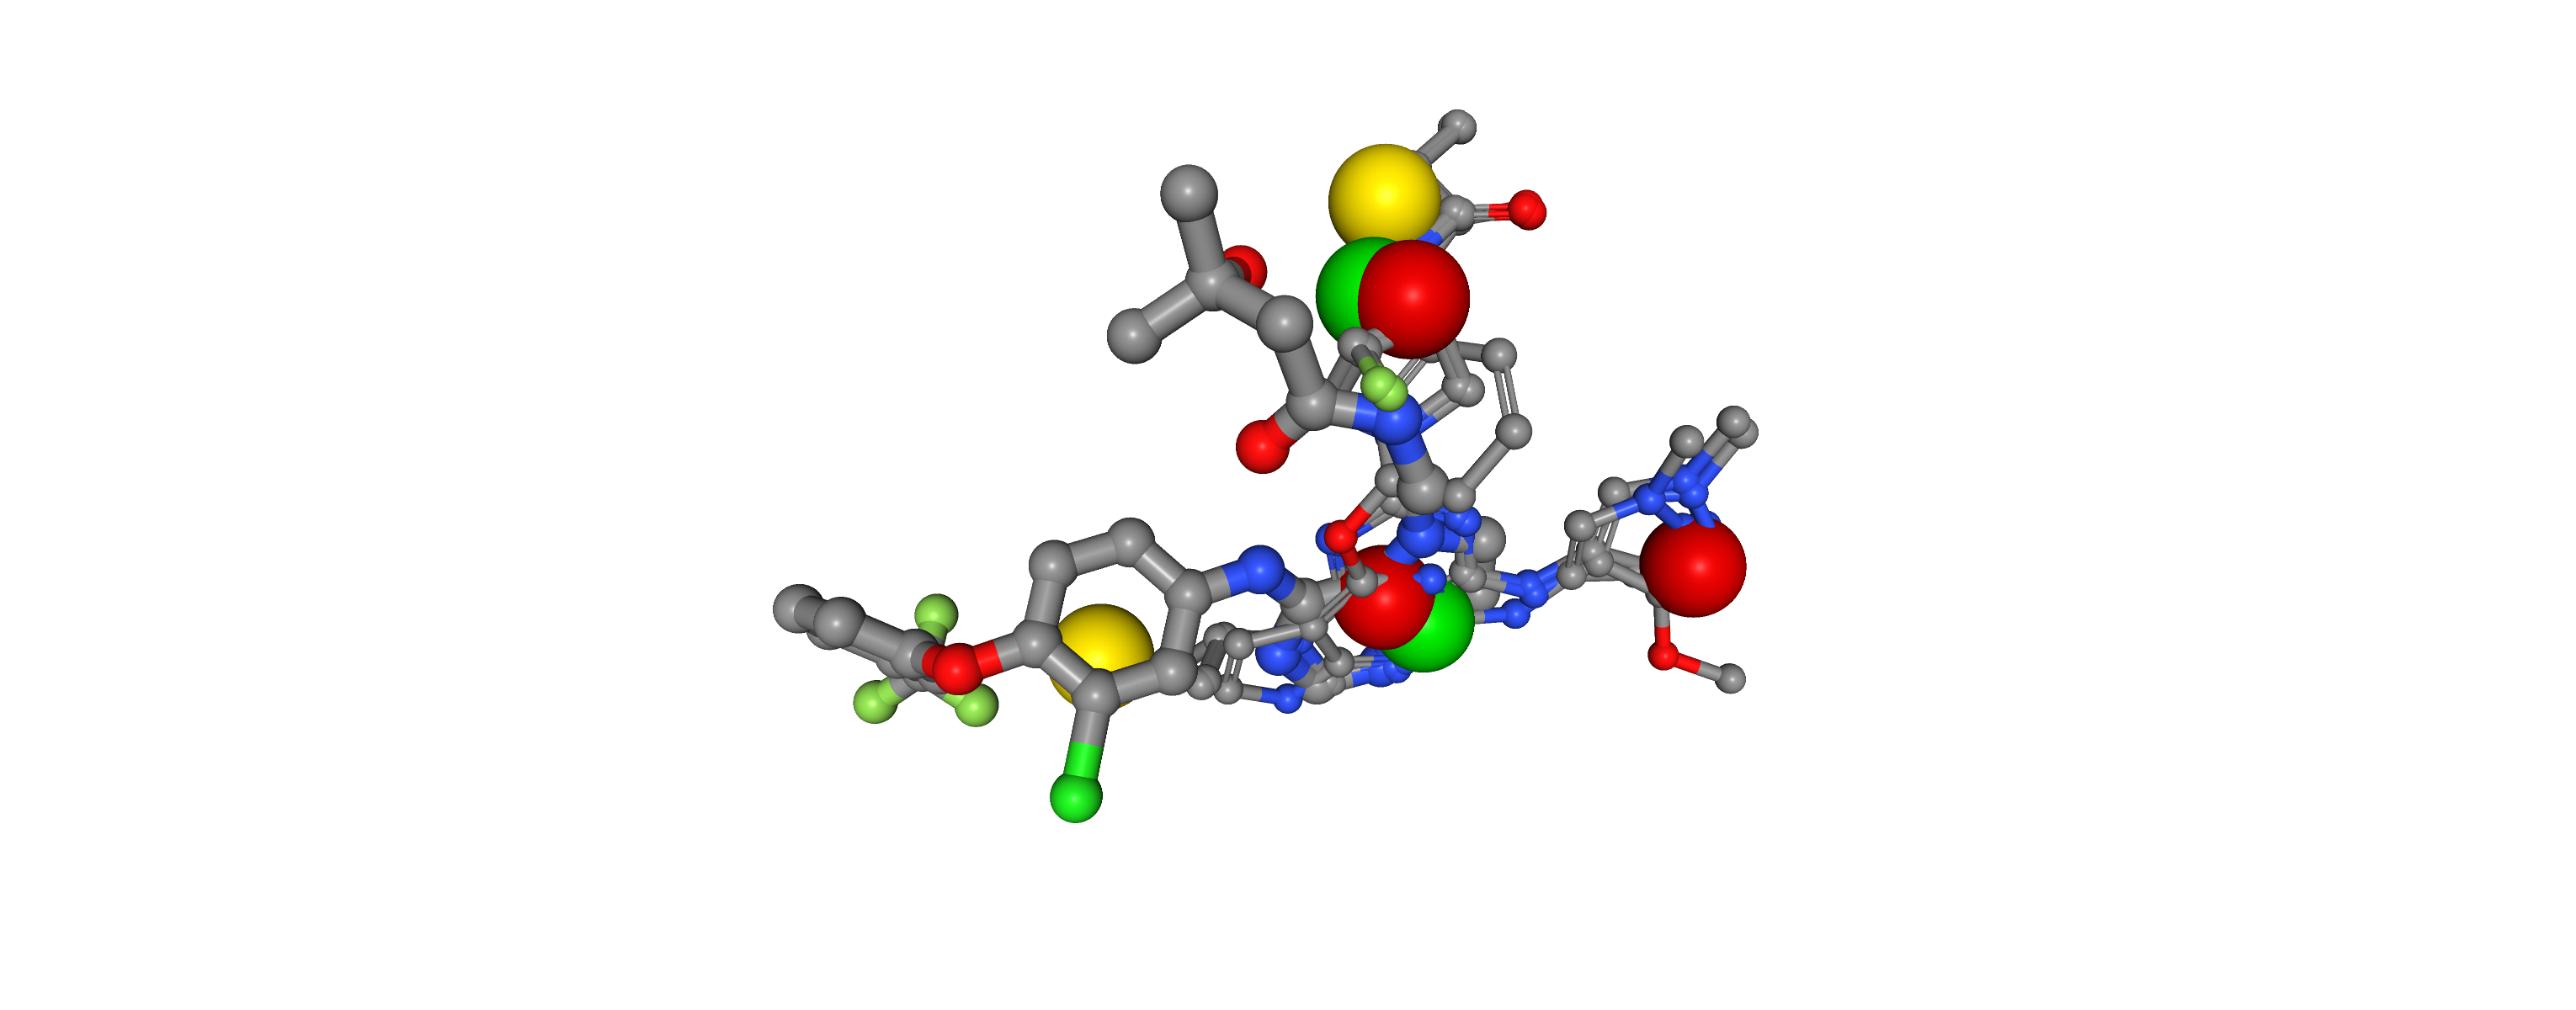

In [83]:
v._display_image()

## ディスカッション

このトークトリアルでは、EGFRに結合することが知られているリガンドのセットを、予め重ね合わせたものを用いて、組み合わせファーマコフォアモデルを作成しました。これで、既知のリガンドに観測された立体的、物理化学的特徴を示し、EGFR結合サイトに結合するかもしれないような新奇な低分子を見つけることを目的として、低分子化合物の巨大なライブラリのバーチャルスクリーニングを行うために、この組み合わせファーマコフォアモデルを使うことができます。

スクリーニングの前に、通常、ファーアマコフォアモデルはさらに最適化されます。例えば、スクリーニングに用いるフィーチャーの特徴の数を減らすために、生物学的な知識（ある相互作用は重要である一方、他の相互作用はそうではないという報告されているかもしれません）、あるいは化学的専門知識に基づいて、いくつかのフィーチャーは除外されるかもしれません。

このトークトリアルではバーチャルスクリーニングは扱いませんが、RDKitを使ってファーマコフォアモデリングとバーチャルスクリーニングをデモンストレーションしている、Nik Stieflによる素晴らしいチュートリアルに言及しておきます。([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)).

ファーマコフォアフィーチャーのクラスタリングを行うためにk平均法クラスタリングを用いました。このクラスタリング手法は、使用者が予めクラスターの数を定義する必要があるという欠点があります。通常、クラスターの数は、クラスタリングの実施前（あるいはクラスターの精度を高めていく過程）に、ポイントの分布を目視で調査して決めるので、ファーマコフォアを自動的に作成するには妨げとなります。この解決策として、密度に基づくクラスタリング手法（とk平均法クラスタリングの組み合わせも）が挙げられます。

## クイズ

1. ファーマコフォアフィーチャーとファーマコフォアを説明してください。
2. 構造ベースのファーマコフォアモデリングとリガンドベースのファーマコフォアモデリングの違いを説明してください。
3. 組み合わせファーマコフォアを導く方法を説明してください。